In [1]:
# File specific for the LSTN_FDST_DATASET.
# We only annotate 3 images per video because otherwise we will have 250GB of data.
# Perhaps it's better to just generate the ground-truth 'on the fly' when training a model.
import math
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import time
from datetime import datetime
import torch
from torch.utils.data import DataLoader
import collections

import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

import random
from scipy import io as sio
import sys
from torch.utils import data
from PIL import Image, ImageOps

import pandas as pd
import torchvision.transforms as standard_transforms

import transforms as own_transforms

%matplotlib inline

In [2]:
class DDCB(nn.Module):
    def __init__(self, in_planes):
        super(DDCB, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, 256, 1), nn.ReLU(True), nn.Conv2d(256, 64, 3, padding=1),
                                   nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes + 64, 256, 1), nn.ReLU(True),
                                   nn.Conv2d(256, 64, 3, padding=2, dilation=2), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_planes + 128, 256, 1), nn.ReLU(True),
                                   nn.Conv2d(256, 64, 3, padding=3, dilation=3), nn.ReLU(True))
        # self.conv4 = nn.Sequential(nn.Conv2d(in_planes + 128, 512, 3, padding=1), nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_planes + 192, 512, 3, padding=1))

    def forward(self, x):
        x1_raw = self.conv1(x)
        x1 = torch.cat([x, x1_raw], 1)
        x2_raw = self.conv2(x1)
        x2 = torch.cat([x, x1_raw, x2_raw], 1)
        x3_raw = self.conv3(x2)
        x3 = torch.cat([x, x1_raw, x2_raw, x3_raw], 1)
        output = self.conv4(x3)

        return output


class DenseScaleNet(nn.Module):
    def __init__(self, load_model=''):
        super(DenseScaleNet, self).__init__()
        self.load_model = load_model
        self.features_cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, ]
        self.features = make_layers(self.features_cfg)
        self.DDCB1 = DDCB(512)
        self.DDCB2 = DDCB(512)
        self.DDCB3 = DDCB(512)
        self.output_layers = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1), nn.ReLU(True),
                                           nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(True), nn.Conv2d(64, 1, 1))
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x1_raw = self.DDCB1(x)
        x1 = x1_raw + x
        x2_raw = self.DDCB2(x1)
        x2 = x2_raw + x1_raw + x
        x3_raw = self.DDCB3(x2)
        x3 = x3_raw + x2_raw + x1_raw + x
        output = self.output_layers(x3)
        output = F.upsample(output, scale_factor=8)
        return output

    def _initialize_weights(self):
        self_dict = self.state_dict()
        pretrained_dict = dict()
        self._random_initialize_weights()
        if not self.load_model:
            mod = models.vgg16(pretrained=True)
            vgg_state_dict = mod.features[0:23].state_dict()

            for k, v in vgg_state_dict.items():
                pretrained_dict['features.' + k] = v

            self_dict.update(pretrained_dict)
            self.load_state_dict(self_dict)
        else:
            
            model = torch.load(self.load_model, map_location=torch.device('cpu'))
            new_model = collections.OrderedDict()
            for old_key in model:
                new_key = old_key[4:]
                new_model[new_key] = model[old_key]
            
            self.load_state_dict(new_model)

    def _random_initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, std=0.01)
                # nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)


def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [3]:
my_net = DenseScaleNet(load_model='all_ep_50_mae_10.4_mse_0.0_DS.pth')

In [4]:
# Maybe windows specific
SHHB_test_base_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img'

In [29]:
class SHHB(data.Dataset):
    def __init__(self, data_path, mode, main_transform=None, img_transform=None, gt_transform=None):
        self.data_path = data_path
        self.data_files = [os.path.join(self.data_path, filename) for filename in os.listdir(self.data_path) \
                           if os.path.isfile(os.path.join(self.data_path, filename))]
        self.data_files = self.data_files[::10]  # Dont use all images
        self.num_samples = len(self.data_files) 
        self.main_transform = main_transform  
        self.img_transform = img_transform
        self.gt_transform = gt_transform     
    
    def __getitem__(self, index):
        fname = self.data_files[index]
        img, den = self.read_image_and_gt(fname)      
        if self.main_transform is not None:
            img, den = self.main_transform(img,den) 
        if self.img_transform is not None:
            img = self.img_transform(img)         
        if self.gt_transform is not None:
            den = self.gt_transform(den)               
        return img, den, fname

    def __len__(self):
        return self.num_samples

    def read_image_and_gt(self,fname):
        gt_path = fname.replace('img', 'den').replace('.jpg', '.csv')
        
        img = Image.open(fname)
        if img.mode == 'L':
            img = img.convert('RGB')
            
        w, h = img.size
        factor = 720 / w
        new_h = round(factor * h)
        new_w = round(factor * w)
        
        img = img.resize((new_w, new_h))
        
        den = pd.read_csv(gt_path, sep=',',header=None).values
        
        den = den.astype(np.float32, copy=False)    
        den = Image.fromarray(den)
        
        return img, den 

    def get_num_samples(self):
        return self.num_samples       
            

In [30]:
mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])
log_para = 100

train_main_transform = None
val_main_transform = None

img_transform = standard_transforms.Compose([
    standard_transforms.ToTensor(),
    standard_transforms.Normalize(*mean_std)
])
gt_transform = standard_transforms.Compose([
    own_transforms.LabelNormalize(log_para)
])
restore_transform = standard_transforms.Compose([
    own_transforms.DeNormalize(*mean_std),
    standard_transforms.ToPILImage()
])

my_dataset = SHHB(SHHB_test_base_path, 'test', None, img_transform, gt_transform)
my_dataloader = DataLoader(my_dataset, batch_size=1, num_workers=0, shuffle=False, drop_last=True)

In [31]:
save_dir = 'DSNet_WE_to_SHHB'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
def save_results(img, gt, pred, save_dir, fname):
    img = restore_transform(img)
    
    pred_count = (pred.sum() / 100).item()
    gt_count = (gt.sum() / 100).item()
    err = pred_count - gt_count
    print(f'{fname}. pred: {pred_count:.3f}, gt: {gt_count:.3f}')

    fname_parts = fname[0].split('\\')
    vid = fname_parts[-2]
    frame = fname_parts[-1][:-4]  # Remove '.jpg'
    
    save_name = f'err_{err:.3f}_vid_{vid}_frame_{frame}.jpg'
    save_path = os.path.join(save_dir, save_name)
    
    fig, axarr = plt.subplots(2, 2) 
    fig.tight_layout()
    
    axarr[0, 0].imshow(img)
    axarr[0, 0].set_title('Input image')
    axarr[0, 1].axis("off")
    axarr[1, 0].imshow(gt.numpy(),cmap=CM.jet)
    axarr[1, 0].set_title(f'gt: {gt_count:.3f}')
    axarr[1, 1].imshow(pred.detach().numpy(),cmap=CM.jet)
    axarr[1, 1].set_title(f'pred: {pred_count:.3f}')
    
    fig.savefig(save_path, dpi=200)

C:\Users\Wight\Anaconda3\envs\GroundTruthGenerator\lib\site-packages\torch\nn\functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\1.jpg',). pred: 23.949, gt: 22.830
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\108.jpg',). pred: 103.768, gt: 138.999
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\117.jpg',). pred: 32.924, gt: 40.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\126.jpg',). pred: 45.792, gt: 56.656
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\135.jpg',). pred: 58.722, gt: 72.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\144.jpg',). pred: 54.269, gt: 58.977
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\153.jpg',). pred: 170.965, gt: 296.829
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\162.jpg',). pred: 44.977, gt: 54.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\171.jpg',

C:\Users\Wight\Anaconda3\envs\GroundTruthGenerator\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\289.jpg',). pred: 47.945, gt: 45.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\298.jpg',). pred: 138.792, gt: 206.659
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\306.jpg',). pred: 137.415, gt: 229.691
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\315.jpg',). pred: 43.076, gt: 54.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\4.jpg',). pred: 80.078, gt: 95.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\49.jpg',). pred: 40.333, gt: 35.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\58.jpg',). pred: 76.477, gt: 96.000
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\67.jpg',). pred: 68.396, gt: 107.656
('D:\\OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\PreGenSHTB\\test\\img\\76.jpg',). 

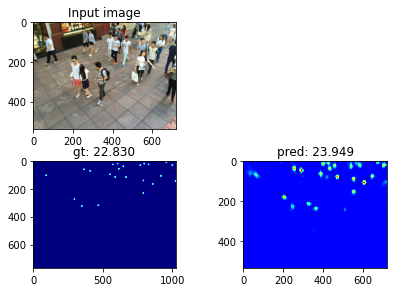

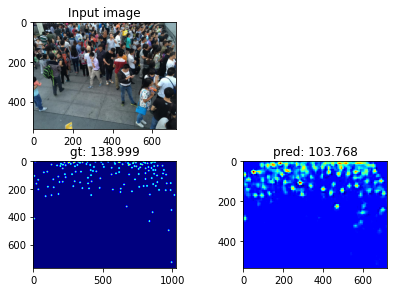

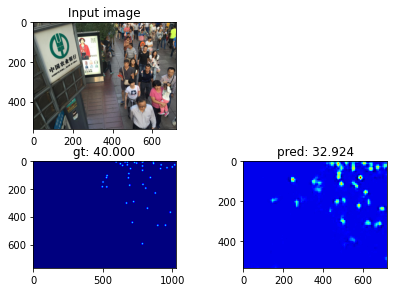

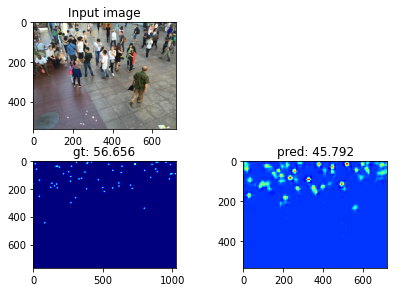

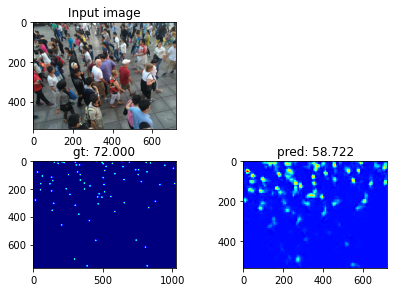

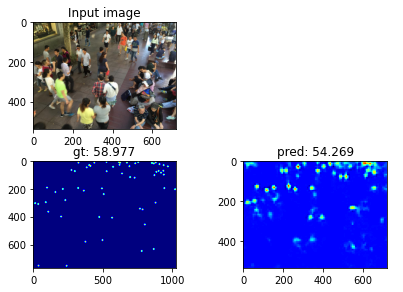

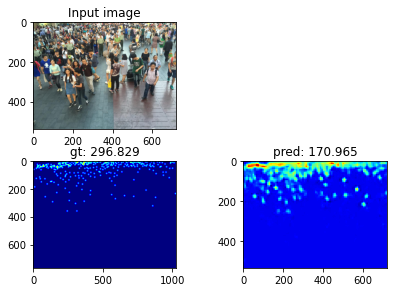

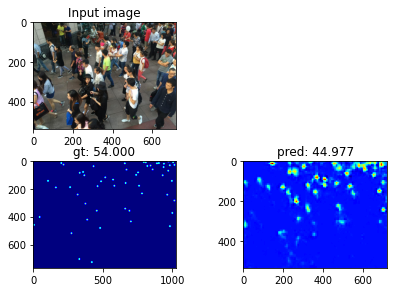

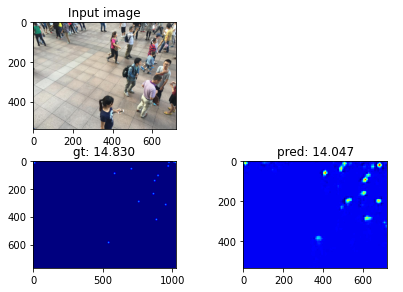

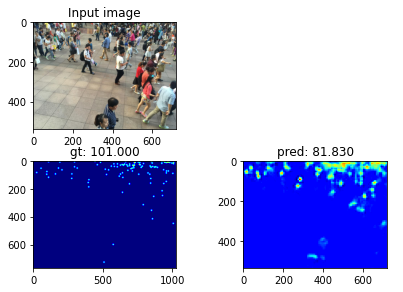

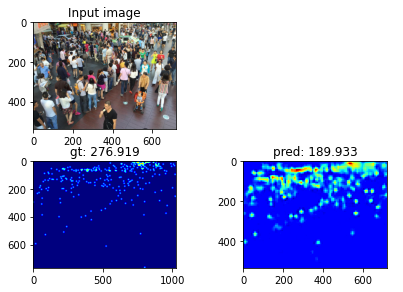

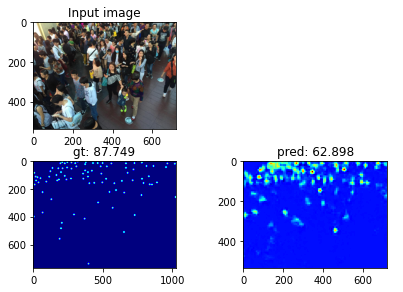

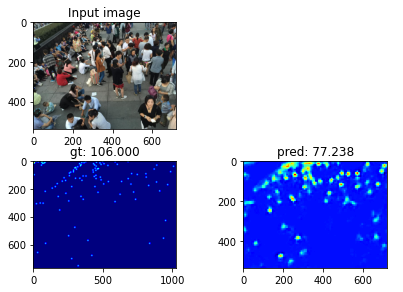

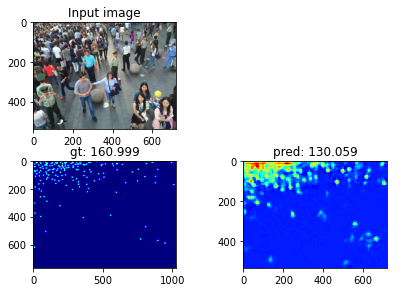

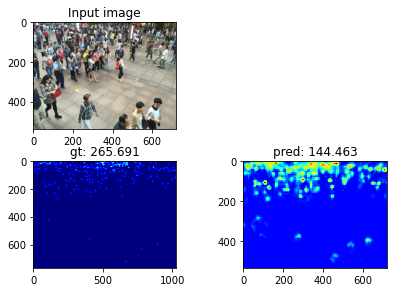

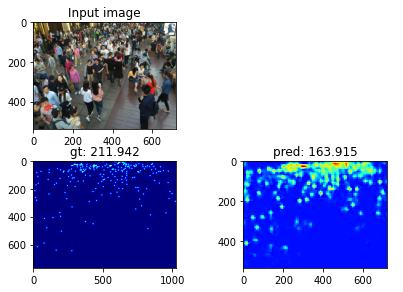

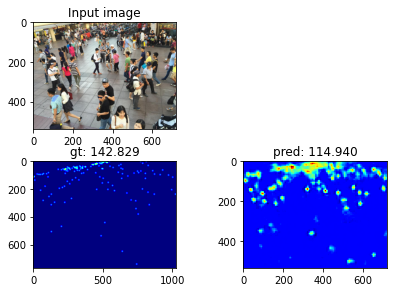

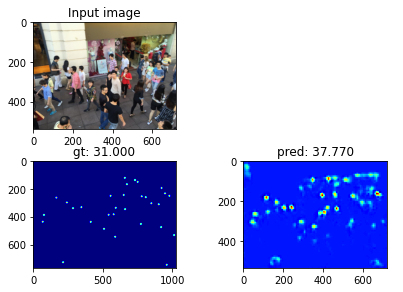

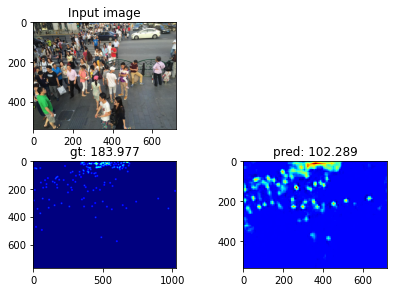

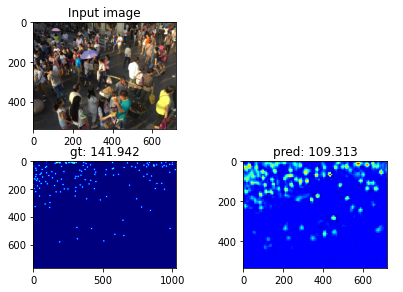

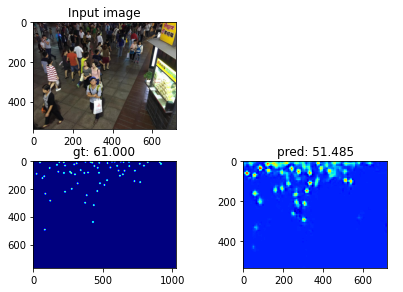

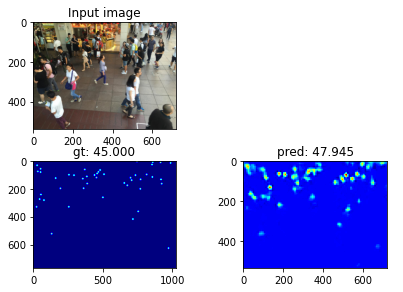

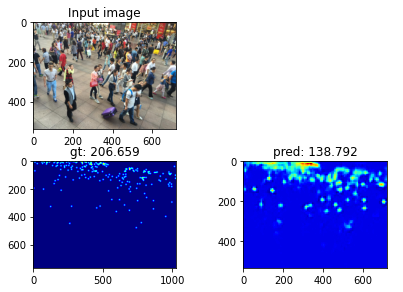

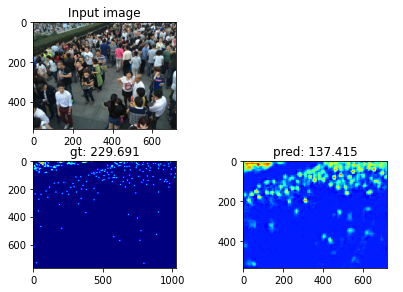

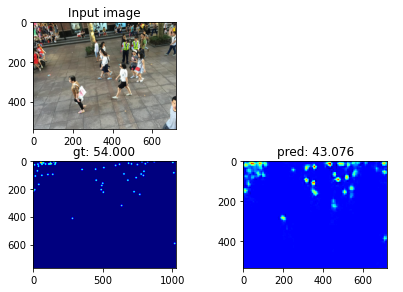

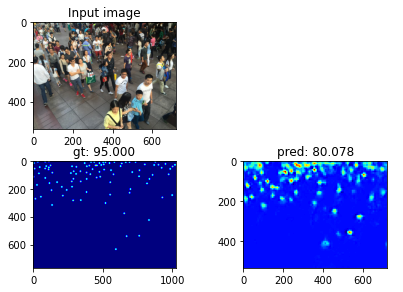

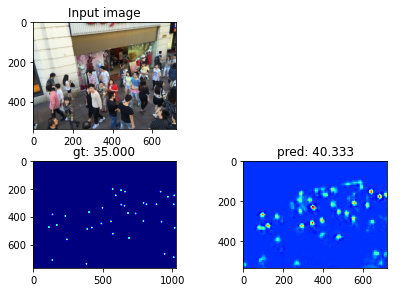

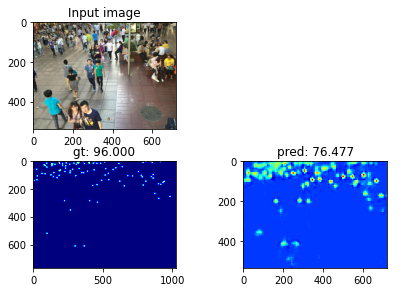

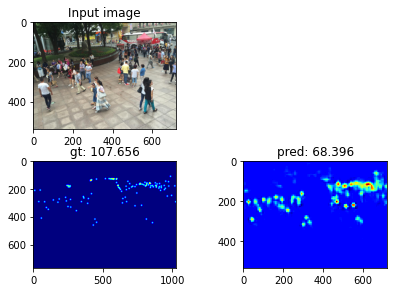

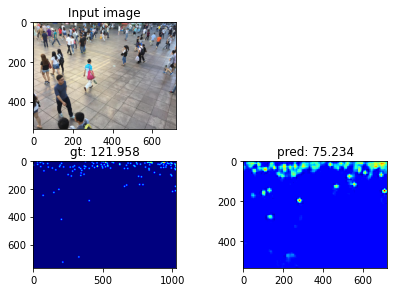

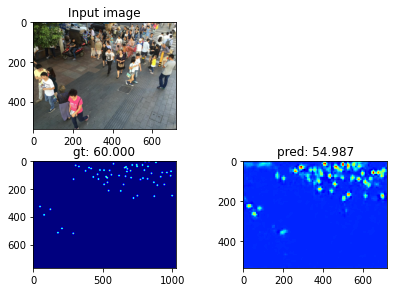

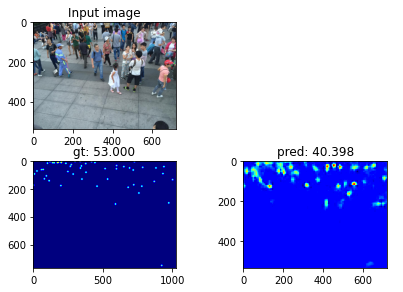

In [33]:
import torch

for idx, (img, gt, fname) in enumerate(my_dataloader):
    
    pred = my_net(img)    
    
    save_results(img.squeeze(), gt.squeeze(), pred.squeeze(), save_dir, fname)
